In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

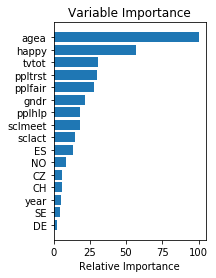

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [5]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

First of all, the data wasn't shuffled, so all of the original test set was likely from a country that wasn't in the training set. Let's start there. Let's also add a couple features that combine the variables that are most influencial from our initial attempt.

In [6]:
df = df.sample(frac=1)

In [ ]:
df.head()

In [7]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
X['age_happy'] = X['agea'] * X['happy']
X['age/tvtot'] = X['agea'] // (X['tvtot'] + 1)
#X['meet_fair'] = X['pplfair'] * X['sclmeet']
#X['trst_act'] = X['ppltrst'] * X['sclact']
#X['meet_fair_help'] = X['sclmeet'] * X['pplfair'] * X['pplhlp']

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Running the model with only those two changes improves accuracy on the test set by about 1/2 a percent. Let's tweak the model and see what changes allow us to do even better.

    Test set accuracy:
    Percent Type I errors: 0.06012269938650307
    Percent Type II errors: 0.18159509202453988

In [8]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance',
          'learning_rate': 0.1,
          'min_samples_split': 20,
          'subsample':1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.0463720676486634
Percent Type II errors: 0.1723949809056192

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.1656441717791411


Original Baseline: 

    Test set accuracy:
    Percent Type I errors: 0.06257668711656442
    Percent Type II errors: 0.18527607361963191

With Shuffle + Three new features: (New baseline)

    Percent Type I errors: 0.06012269938650307
    Percent Type II errors: 0.18159509202453988
    
max_depth=3: (overfit - got worse)

    Percent Type I errors: 0.08220858895705521
    Percent Type II errors: 0.18282208588957055
    
estimators=700: (moved Type II errors to Type I)

    Percent Type I errors: 0.06134969325153374
    Percent Type II errors: 0.17914110429447852
    
loss='exponential': (got worse)

    Percent Type I errors: 0.06257668711656442
    Percent Type II errors: 0.18650306748466258
    
learning_rate=0.05: (lower Type I, higher Type II)
    
    Percent Type I errors: 0.051533742331288344
    Percent Type II errors: 0.19141104294478528
    
learning_rate=0.2: (higher T1, lower T2)

    Percent Type I errors: 0.07607361963190185
    Percent Type II errors: 0.18036809815950922
    
It seems like we're dealing with a trade off here: As we train the model more, Type II goes down but Type I error goes up. This would be a good time to decide which type of error we're more comfortable with.

min_samples_split=20: (prevents splits with very little information -- T1 decrease) New Baseline.

    Percent Type I errors: 0.05889570552147239
    Percent Type II errors: 0.18159509202453988
    
subsample=0.8: (got worse, varies each time you run it)

    Percent Type I errors: 0.0638036809815951
    Percent Type II errors: 0.18773006134969325
    
So far the best thing has been adding more features. Let's try some more of that. (Got a little bit worst again)

    Percent Type I errors: 0.06012269938650307
    Percent Type II errors: 0.18527607361963191
    
Okay. What if we change she size of the test set? Offset = 0.8:

    Percent Type I errors: 0.11901840490797547
    Percent Type II errors: 0.14539877300613496
    
Now that actually did something! We converted a substantial portion of our T2 error to T1 error. Total error increased slightly, but at least something happened. But decreasing it further brings us back to the same realm we were in before. Weird. Offset = 0.7: 

    Percent Type I errors: 0.05603271983640082
    Percent Type II errors: 0.19222903885480572
    
I'm running out of ideas for changes to make...

Maybe this is the best we can do? I could try endless combinations of these parameters, but what seems to be happening is that every time I decrease T2 error by a little bit, it comes at the expense of a larger increase in T1 error. Which basically means, in order to correctly classify 10 more points, we'll misclassify another 20. The tiny improvements we got were from shuffling the dataset, adding a couple highly effective features, and increasing the min_samples_split.

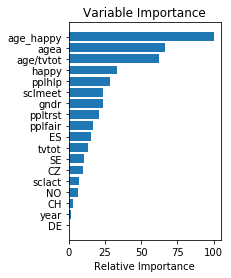

In [9]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

gridsearchCV goes through lots of parameters.

In [10]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_search = [{'n_estimators': [300, 500, 700],
          'max_depth': [2, 3],
          'loss': ['deviance'],
          'learning_rate': [0.03, 0.1, 0.3],
          'min_samples_split': [2, 20],
          'subsample':[.9, 1]}]

In [25]:
grid_search = GridSearchCV(ensemble.GradientBoostingClassifier(), param_grid=param_search, cv=5)

In [26]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [300, 500, 700], 'max_depth': [2, 3], 'loss': ['deviance'], 'learning_rate': [0.03, 0.1, 0.3], 'min_samples_split': [2, 20], 'subsample': [0.9, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [27]:
grid_search.best_score_

0.75641025641025639

In [28]:
grid_search.best_params_

{'learning_rate': 0.03,
 'loss': 'deviance',
 'max_depth': 2,
 'min_samples_split': 20,
 'n_estimators': 700,
 'subsample': 1}

In [29]:
params = grid_search.best_params_

In [30]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.046917621385706494
Percent Type II errors: 0.18466993998908893

Test set accuracy:
Percent Type I errors: 0.053987730061349694
Percent Type II errors: 0.17668711656441718


Cool! It found a slightly different best_params than I did. This will make everything a lot easier! I could have used a larger grid, but these values made sense based on the exploration I had done, and every additional parameter choice significantly bumps up processing time. 